# 데이터셋 얻는법 #

> https://finance.yahoo.com으로 접속해서 Samsung Electronics Co.를 검색한다.
    여기서 historycal data를 누르고 time period - 5Y - Done - Apply를 눌러준     다. download 버튼을 누르면 csv파일 형태로 다운로드 할 수 있다. 받은 엑셀     파일을 실행시키고 ctrl+A를 한 후 데이터 - 정렬을 누르고 date 기준 오름차     순을 선택해준다. 다 마치면 사용할 데이터가 완성이 된다.
    

# 사용할 패키지

> csv 파일을 읽기 위한 pandas, 행렬 연산을 위한 numpy, 예측한 데이터를 시각화하는 matplotlib.pyplot, 딥러닝 모델을 작성하기 위해서 keras를 사용한다.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import datetime

# Load dataset

> 삼성전자 csv 파일을 pandas의 read_csv함수를 이용해 읽어온다(주소/파일명). 읽어온 데이터를 data라는 변수에 넣고서 head라는 명령어를 치면은 데이터 프레임 맨 앞 5줄 데이터가 출력된다

In [20]:
data = pd.read_csv('C:\Jupyter_Project/005930.KS.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-28,23280.0,23360.0,22780.0,22900.0,1099.987793,15795600.0
1,2016-01-29,22800.0,23000.0,22320.0,23000.0,1104.791382,21849150.0
2,2016-02-01,23040.0,23260.0,23020.0,23260.0,1117.280273,12998950.0
3,2016-02-02,23220.0,23320.0,22940.0,23120.0,1110.555420,8317400.0
4,2016-02-03,23000.0,23040.0,22740.0,22920.0,1100.948608,8725350.0


# Compute Mid Price 

> 최고가와 최저가의 중간가격 mid_prices를 예측한다. high price와 low price를 더한 뒤 2로 나누고 mid_prices에 저장해준다.

In [21]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

# Create Windows

> LSTM의 기본 개념은 최근 50일간의 데이터를 보고 내일 것을 예측한다. seq_len은 window size이고, 다음을 예측하는 모델이다. 계속 바꿀 수 있다. create Window의 의미는 window에 들어가는 데이터의 수는 51개이다. 그 이후 for문을 돌면서 result라는 리스트에다 한스텝씩 넘어가면서 저장을 하게 된다.

||High|Low|Mid|
|---|---|---|---|
|2018-10-01||||
|2018-10-02||||
|2018-10-03||||
|...||||
|2018-11-30||||
|2018-12-01||||
|2018-12-02||||
|2018-12-03||||
|...||||
>첫번째 윈도우는 시작일부터 50일+1일, 두번째 윈도우는 시작일 다음 날부터 50일+1일, 세번째 윈도우는 시작일로부터 이틀 뒤부터 50일+1일을 만들어 하나하나씩 예측을 시행할 것이다.

In [22]:
seq_len = 50
sequence_length = seq_len+1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

# Normalize Data

> 데이터를 정규화해준다. 모델이 더 잘 예측하게 된다. 정규화 해주는 이유는 모델이 더 잘 예측하게 하기 위해서이다. 정규화 방식은 다음과 같다. 첫번째 윈도우의 mid값을 0으로 잡고 그 비율만큼 나머지 값을 다 정해준다. 윈도우를 싹 훑으면서 각 값을 첫번째 값(0)에서 나눠준 뒤에 1을 빼준다.((A/A)-1), ((02/01)-1),,, 하면 정규화된 Window 값을 얻게 된다. 그 결과 값을 다시 result에 넣어준다.
  그 다음에 해야 할 일은 트레이닝 데이터랑 테스트 데이터를 나눠줘야 한다. Test Set은 학습할 때 포함시키면 절대로 안된다. 따라서 데이터의 0.9만큼을 곱해주면 된다. 그리고 trainset을 random으로 셔플한다. 순서대로 하면 익숙해지기 때문에. trainset의 input과 output을 정해줘야 하는데 window마다 51개의 데이터가 들어가 있기 때문에 x_train에 50개를 넣고 y_train에 1개를 넣는다. 돌리면 1057개의 training set과 117개의 testset이 나온다. 돌리면 1058일 동안 주식을 배워서 117일 동안 테스트 할 것이다.


|Training Set(90%)|Test Set(10%)|
|---|---|



In [2]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

print(y_test)

NameError: name 'result' is not defined

# Build a Model

> sequential()이라는 클래스를 사용할 것이고, LSTM이라는 모듈이 존재한다. input size를 (50,1)로 지정한다. 첫번째 LSTM의 유닛수는 50개이고, 두번째 LSTM의 유닛수는 64개이다. 아웃풋은 다음날 한개의 데이터를 예측한다. lossfunction 손실함수는 Mean Squared Error를 써주고 optimizer는 rmsprop을 사용할 것이다. model summary로 모델의 개요를 출력한다.

In [24]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50,1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# Training

>model에서 fit이라는 method에 trainset, validation data에 test를 넣어주고 batch sizes는 한번에 몇개씩 묶어서 학습시킬 것이냐 10개씩, 에폭스는 20번동안 반복해서 학습시킨다.  

In [ ]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)
print(validation_data)

Epoch 1/20
106/106 [==============================] - 3s 25ms/step - loss: nan - val_loss: nan
Epoch 2/20
106/106 [==============================] - 3s 26ms/step - loss: nan - val_loss: nan
Epoch 3/20
106/106 [==============================] - 3s 24ms/step - loss: nan - val_loss: nan
Epoch 4/20
106/106 [==============================] - 3s 24ms/step - loss: nan - val_loss: nan
Epoch 5/20
106/106 [==============================] - 3s 25ms/step - loss: nan - val_loss: nan
Epoch 6/20
106/106 [==============================] - 3s 24ms/step - loss: nan - val_loss: nan
Epoch 7/20
106/106 [==============================] - 3s 24ms/step - loss: nan - val_loss: nan
Epoch 8/20
106/106 [==============================] - 3s 27ms/step - loss: nan - val_loss: nan
Epoch 9/20
106/106 [==============================] - 3s 24ms/step - loss: nan - val_loss: nan
Epoch 10/20
106/106 [==============================] - 2s 23ms/step - loss: nan - val_loss: nan
Epoch 11/20
106/106 [============================

# Prediction

>model.predict를 사용해서 test 데이터를 예측한다. 예측한 결과를 pred에 둔 다음에 그래프로 그린다. 그 결과 다음과 같은 결과가 나온다.

In [1]:
x_test = x_test.astype(float)
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='prediction')
ax.legend()
plt.show()

NameError: name 'x_test' is not defined

[ 0.14243323  0.15039841  0.13752456  0.14662757  0.09372071  0.05376344
  0.05641492  0.0602518   0.05500451  0.01895307  0.04062789  0.0738255
  0.10794897  0.09250243  0.07389635  0.07507218  0.05358852  0.04310345
  0.05101059  0.06350711  0.05719733  0.06597549  0.10171103  0.09746954
  0.12358491  0.12        0.13546566  0.11672794  0.11527905  0.12453184
  0.11842105  0.12796209  0.09915809  0.08598131  0.063129    0.06721915
  0.07261029  0.07720588  0.05898367  0.07622505  0.09124424  0.1119334
  0.09363636  0.05729167  0.02184874  0.01175483  0.01790281  0.04450262
  0.05125977  0.07293497  0.04155844  0.04069264  0.04663212  0.02131287
  0.01285347 -0.01360544 -0.0129199  -0.03731976 -0.0042735   0.03454384
  0.05678793  0.075       0.07174491  0.06951872  0.08847185  0.09310654
  0.1280654   0.19926538  0.21428571  0.16666667  0.16050496  0.14146773
  0.14322692  0.16567037  0.131822    0.13945578  0.12676056  0.11358025
  0.11074651  0.15070774  0.17478992  0.19495798  0.2

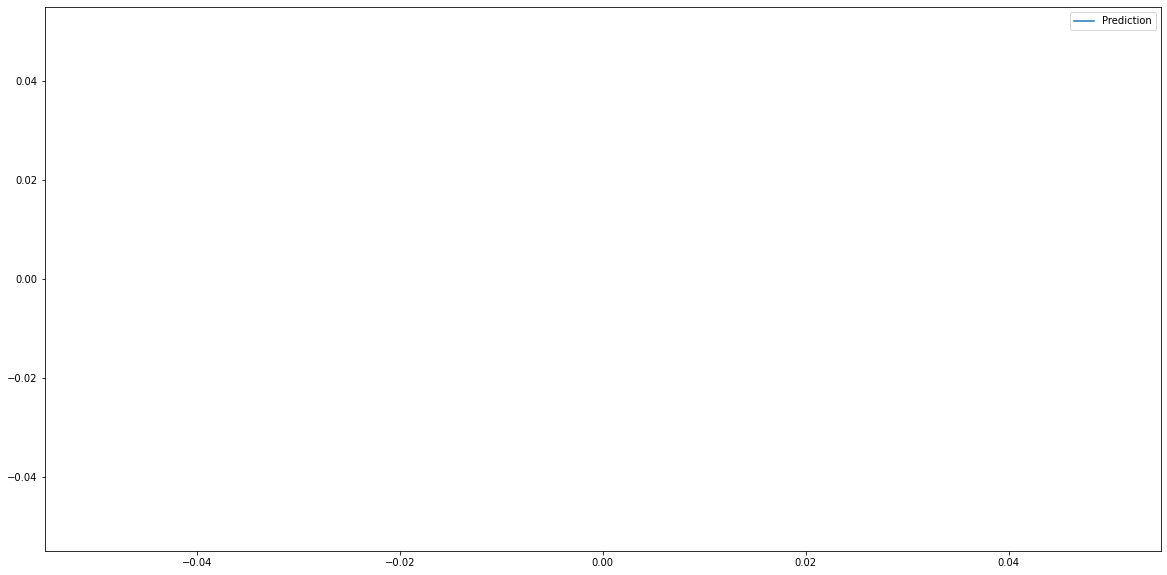

In [29]:
pred = model.predict(x_test)
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)

ax.plot(pred, label='Prediction')
ax.legend()
plt.show()